In [4]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [1]:
import os
import sys
sys.path.append(os.path.abspath('../skin_lesion_cad'))
from tqdm import tqdm
from pathlib import Path
from collections import Counter
import multiprocessing as mp

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools
from scipy.stats import entropy, skew, kurtosis


from features.colour import ColorFeaturesExtractor

In [2]:
def process_img(img_path):
    img = cv2.imread(str(img_path))
    img = cv2.medianBlur(img, 3)
    mask = cv2.imread(str(img_path).replace('inpaint', 'mask'), cv2.IMREAD_GRAYSCALE)
    mask = img[:,:,0]>-100
    img_name = img_path.name.split('_')[0]
    imf_fearures = cfe.extract_masked(img, mask)
    imf_fearures['name'] = img_name
    return imf_fearures

In [3]:
proc_data = Path().resolve().parent / 'data/processed'

color_spaces = {'bgr':cv2.COLOR_RGB2BGR, 'hsv':cv2.COLOR_RGB2HSV, 'lab':cv2.COLOR_RGB2LAB,  'YCrCb':cv2.COLOR_RGB2YCrCb}
mshift_params = {'sp': 10, 'sr': 15} # spatial and color range radius

# Data Extraction

In [5]:
chl = 'chall2'
mode = 'train'

for t in ['raw', 'meanshift']:
    for cls in ['bcc', 'mel', 'scc']:

        test_path = proc_data / f'{chl}/{mode}/{cls}'
        if t == 'meanshift':
            cfe = ColorFeaturesExtractor(color_spaces, mshift_params)
        elif t == 'skincolnorm':
            cfe = ColorFeaturesExtractor(color_spaces, rel_col=True)
        else:
            cfe = ColorFeaturesExtractor(color_spaces)

        all_imgs = list(test_path.glob('*inpaint_0_5*'))

        candidates_features = []
        with mp.Pool(6) as pool:
            for result in tqdm(pool.imap(process_img, all_imgs), total=len(all_imgs)):
                candidates_features.append(result)
                
                
        df = pd.DataFrame(candidates_features)
        df.to_feather(test_path.parent/f'{test_path.name}_color_features_{t}_ull.feather')

  0%|          | 0/1993 [00:00<?, ?it/s]/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encou

### Showing intermididate results

In [24]:
# all_imgs = list(test_path.glob('*inpaint_0_5*'))

# timg = cv2.imread(str(all_imgs[0]))
# timg = cv2.cvtColor(timg, cv2.COLOR_RGB2BGR)

# mshift = cv2.pyrMeanShiftFiltering(timg, **mshift_params)

In [ ]:
# chl = 'chall1'
# mode = 'train'
# cls = 'nevus'

# test_path = proc_data / f'{chl}/{mode}/{cls}'

# for timgp in list(test_path.glob('*inpaint_0_5*'))[:10]:

#     timg = cv2.imread(str(timgp))
#     mask = cv2.imread(str(timgp).replace('inpaint', 'mask'), cv2.IMREAD_GRAYSCALE)

#     timg = cv2.cvtColor(timg, cv2.COLOR_RGB2BGR)

#     mshift = cv2.pyrMeanShiftFiltering(timg, **mshift_params)

#     fig, axs =plt.subplots(1, 3, figsize=(10, 5))

#     axs[0].imshow(timg)
#     axs[0].axis('off')
#     axs[1].imshow(mshift)
#     axs[1].axis('off')
#     axs[2].imshow(mask)
#     axs[2].axis('off')
    
#     plt.tight_layout()
#     plt.show()


In [ ]:
# chl = 'chall1'
# mode = 'train'
# cls = 'others'

# test_path = proc_data / f'{chl}/{mode}/{cls}'

# for timgp in list(test_path.glob('*inpaint_0_5*'))[:10]:

#     timg = cv2.imread(str(timgp))
#     mask = cv2.imread(str(timgp).replace('inpaint', 'mask'), cv2.IMREAD_GRAYSCALE)

#     timg = cv2.cvtColor(timg, cv2.COLOR_RGB2BGR)

#     mshift = cv2.pyrMeanShiftFiltering(timg, **mshift_params)

#     fig, axs =plt.subplots(1, 3, figsize=(10, 5))

#     axs[0].imshow(timg)
#     axs[0].axis('off')
#     axs[1].imshow(mshift)
#     axs[1].axis('off')
#     axs[2].imshow(mask)
#     axs[2].axis('off')
    
#     plt.tight_layout()
#     plt.show()


# Data Analysis

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder


from visualization.utils import plot_roc_curve, roc_auc_score_multiclass

### Challenge 1


Analyzing features for raw
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2302
           1       0.80      0.82      0.81      2257

    accuracy                           0.81      4559
   macro avg       0.81      0.81      0.81      4559
weighted avg       0.81      0.81      0.81      4559

Confusion Matrix
 [[1840  462]
 [ 404 1853]]

Accuracy:  0.8100460627330555


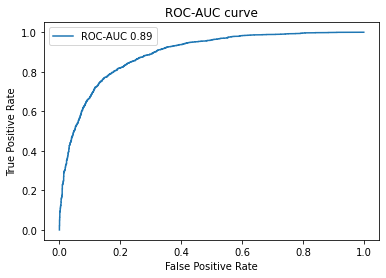


Analyzing features for meanshift
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2302
           1       0.80      0.82      0.81      2257

    accuracy                           0.81      4559
   macro avg       0.81      0.81      0.81      4559
weighted avg       0.81      0.81      0.81      4559

Confusion Matrix
 [[1849  453]
 [ 412 1845]]

Accuracy:  0.8102654090809388


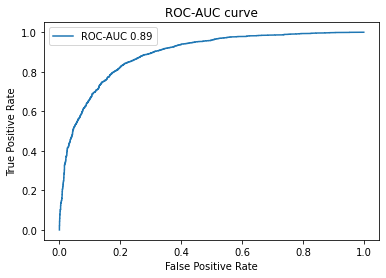

In [10]:
chl = 'chall1'
mode = 'train'



for feat_type in ['raw', 'meanshift']:
    test_path = proc_data / f'{chl}/{mode}/{feat_type}'

    print('\nAnalyzing features for', feat_type)
    nevus_data = pd.read_feather(test_path.parent / f'nevus_color_features_{feat_type}_ull.feather').set_index('name')
    nevus_data['class'] = 0
    others_data = pd.read_feather(test_path.parent/ f'others_color_features_{feat_type}_ull.feather').set_index('name')
    others_data['class'] = 1

    data = pd.concat([nevus_data, others_data])

    all_X = data.drop(columns=['class']).values
    all_y = data['class'].values


    all_X[np.isnan(all_X)] = 0
    all_X[np.isinf(all_X)] = 0

    X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)

    print(classification_report(y_test, y_pred))
    print('Confusion Matrix\n',confusion_matrix(y_test, y_pred))
    print('\nAccuracy: ', accuracy_score(y_test, y_pred))
    plot_roc_curve(y_test, svc.predict_proba(X_test)[:,1])


Analyzing features for raw
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      2302
           1       0.77      0.80      0.78      2257

    accuracy                           0.78      4559
   macro avg       0.78      0.78      0.78      4559
weighted avg       0.78      0.78      0.78      4559

Confusion Matrix
 [[1763  539]
 [ 456 1801]]

Accuracy:  0.7817503838561088


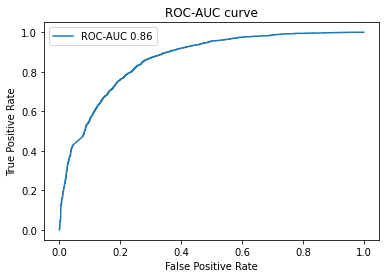


Analyzing features for meanshift
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2302
           1       0.95      0.98      0.96      2257

    accuracy                           0.96      4559
   macro avg       0.96      0.96      0.96      4559
weighted avg       0.96      0.96      0.96      4559

Confusion Matrix
 [[2190  112]
 [  55 2202]]

Accuracy:  0.9633691599034876


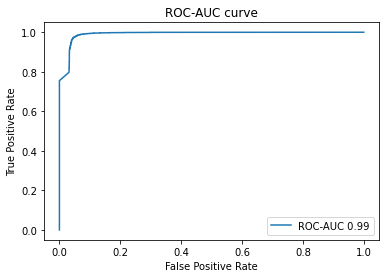


Analyzing features for skincolnorm
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2302
           1       0.77      0.76      0.77      2257

    accuracy                           0.77      4559
   macro avg       0.77      0.77      0.77      4559
weighted avg       0.77      0.77      0.77      4559

Confusion Matrix
 [[1776  526]
 [ 531 1726]]

Accuracy:  0.7681509102873437


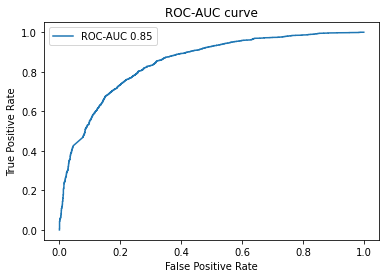

In [28]:
chl = 'chall1'
mode = 'train'



for feat_type in ['raw', 'meanshift', 'skincolnorm']:
    test_path = proc_data / f'{chl}/{mode}/{feat_type}'

    print('\nAnalyzing features for', feat_type)
    nevus_data = pd.read_feather(test_path.parent / f'nevus_color_features_{feat_type}.feather').set_index('name')
    nevus_data['class'] = 0
    others_data = pd.read_feather(test_path.parent/ f'others_color_features_{feat_type}.feather').set_index('name')
    others_data['class'] = 1

    data = pd.concat([nevus_data, others_data])

    all_X = data.drop(columns=['class']).values
    all_y = data['class'].values


    all_X[np.isnan(all_X)] = 0
    all_X[np.isinf(all_X)] = 0

    X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)

    print(classification_report(y_test, y_pred))
    print('Confusion Matrix\n',confusion_matrix(y_test, y_pred))
    print('\nAccuracy: ', accuracy_score(y_test, y_pred))
    plot_roc_curve(y_test, svc.predict_proba(X_test)[:,1])

### Challenge 2


Analyzing features for raw
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       598
           1       0.85      0.88      0.86       814
           2       0.67      0.02      0.03       113

    accuracy                           0.80      1525
   macro avg       0.75      0.58      0.56      1525
weighted avg       0.79      0.80      0.77      1525

Confusion Matrix
 [[507  91   0]
 [100 713   1]
 [ 75  36   2]]

Accuracy 0.801311475409836

F1-score avg 0.7733879974237214


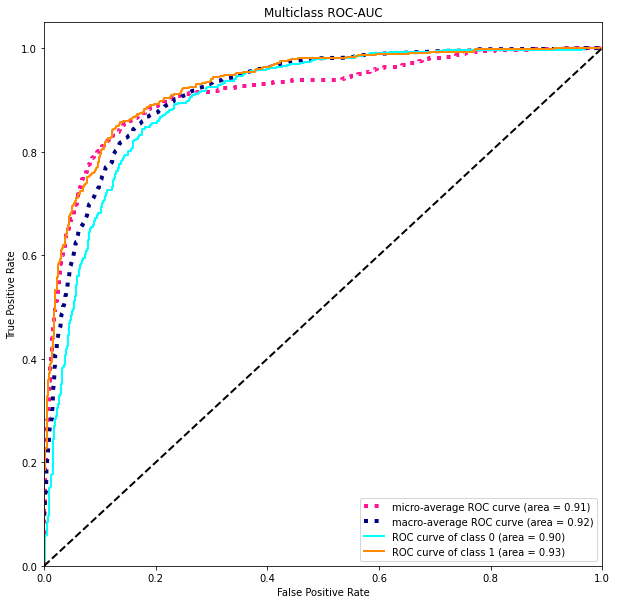


Analyzing features for meanshift


/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       598
           1       0.84      0.88      0.86       814
           2       0.00      0.00      0.00       113

    accuracy                           0.80      1525
   macro avg       0.53      0.57      0.55      1525
weighted avg       0.74      0.80      0.77      1525

Confusion Matrix
 [[505  93   0]
 [101 713   0]
 [ 74  39   0]]

Accuracy 0.7986885245901639

F1-score avg 0.7687047363148711


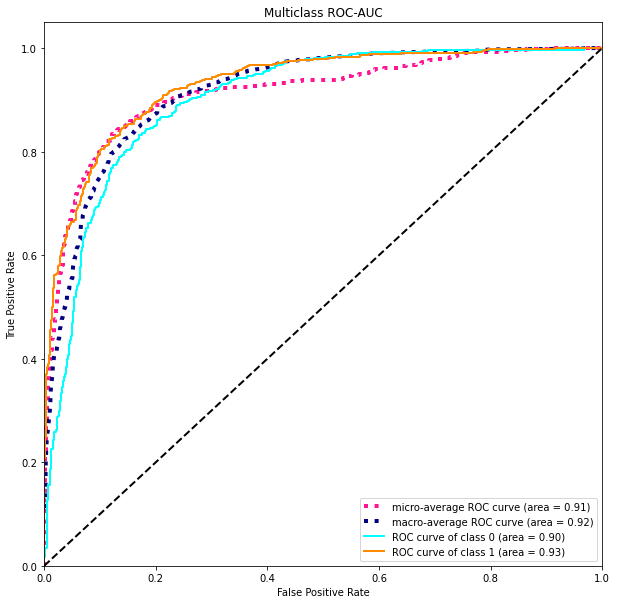

In [8]:
chl = 'chall2'
mode = 'train'


for feat_type in ['raw', 'meanshift']:
    
    test_path = proc_data / f'{chl}/{mode}'
    print('\nAnalyzing features for', feat_type)
    
    bcc_data = pd.read_feather(test_path / f'bcc_color_features_{feat_type}_ull.feather').set_index('name')
    bcc_data['class'] = 0
    
    mel_data = pd.read_feather(test_path/ f'mel_color_features_{feat_type}_ull.feather').set_index('name')
    mel_data['class'] = 1
    
    scc_data = pd.read_feather(test_path/ f'scc_color_features_{feat_type}_ull.feather').set_index('name')
    scc_data['class'] = 2
    
    data = pd.concat([scc_data, bcc_data, mel_data])

    all_X = data.drop(columns=['class']).values
    all_y = data['class'].values
    

    all_X[np.isnan(all_X)] = 0
    all_X[np.isinf(all_X)] = 0
    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_idxs, test_idxs = next(split.split(all_X, all_y))
    X_train, X_test, y_train, y_test  = all_X[train_idxs], all_X[test_idxs], all_y[train_idxs], all_y[test_idxs]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)

    print(classification_report(y_test, y_pred))
    print('Confusion Matrix\n',confusion_matrix(y_test, y_pred))
    print('\nAccuracy', accuracy_score(y_test, y_pred))
    print('\nF1-score avg', f1_score(y_test, y_pred, average='weighted'))
    
    enc = OneHotEncoder()
    y_test_oh = enc.fit_transform(y_test.reshape(-1,1)).toarray()
    roc_auc_score_multiclass(svc, X_test, y_test_oh)


Analyzing features for raw


/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       598
           1       0.82      0.87      0.84       814
           2       0.00      0.00      0.00       113

    accuracy                           0.77      1525
   macro avg       0.51      0.55      0.53      1525
weighted avg       0.71      0.77      0.74      1525

Confusion Matrix
 [[467 131   0]
 [106 708   0]
 [ 84  29   0]]

Accuracy 0.7704918032786885

F1-score avg 0.741190383667179


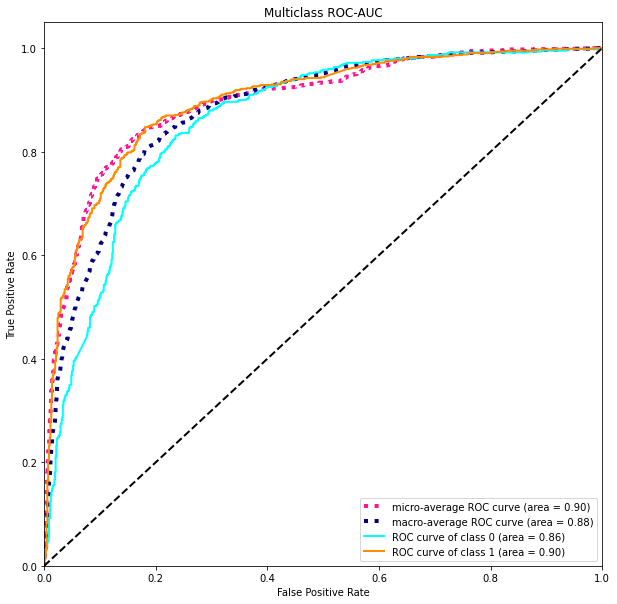


Analyzing features for meanshift


/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       598
           1       0.82      0.86      0.84       814
           2       0.00      0.00      0.00       113

    accuracy                           0.77      1525
   macro avg       0.51      0.55      0.53      1525
weighted avg       0.71      0.77      0.74      1525

Confusion Matrix
 [[471 127   0]
 [111 703   0]
 [ 81  32   0]]

Accuracy 0.7698360655737705

F1-score avg 0.7407134412676876


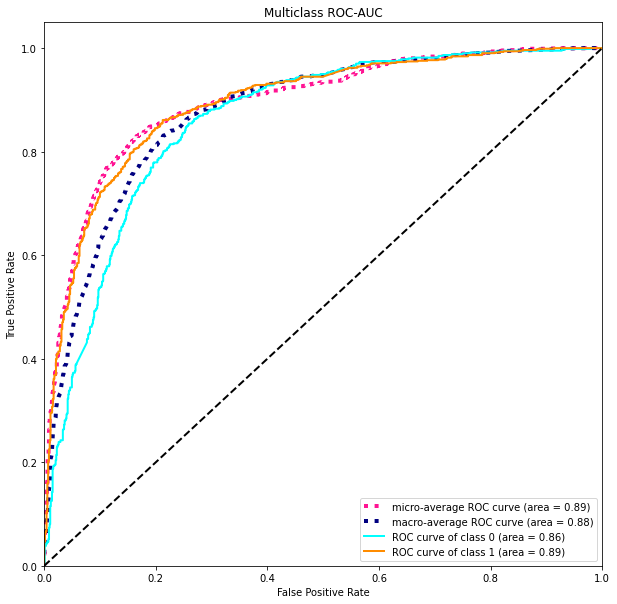


Analyzing features for skincolnorm


/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vzalevskyi/anaconda3/envs/cad_skin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       598
           1       0.79      0.85      0.82       814
           2       0.00      0.00      0.00       113

    accuracy                           0.75      1525
   macro avg       0.49      0.53      0.51      1525
weighted avg       0.69      0.75      0.72      1525

Confusion Matrix
 [[447 151   0]
 [119 695   0]
 [ 76  37   0]]

Accuracy 0.7488524590163934

F1-score avg 0.7199213231923571


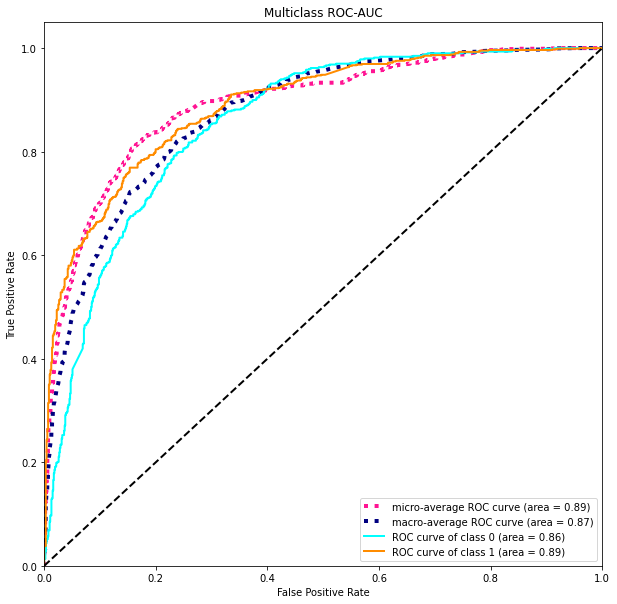

In [6]:
chl = 'chall2'
mode = 'train'


for feat_type in ['raw', 'meanshift', 'skincolnorm']:
    
    test_path = proc_data / f'{chl}/{mode}'
    print('\nAnalyzing features for', feat_type)
    
    bcc_data = pd.read_feather(test_path / f'bcc_color_features_{feat_type}.feather').set_index('name')
    bcc_data['class'] = 0
    
    mel_data = pd.read_feather(test_path/ f'mel_color_features_{feat_type}.feather').set_index('name')
    mel_data['class'] = 1
    
    scc_data = pd.read_feather(test_path/ f'scc_color_features_{feat_type}.feather').set_index('name')
    scc_data['class'] = 2
    
    data = pd.concat([scc_data, bcc_data, mel_data])

    all_X = data.drop(columns=['class']).values
    all_y = data['class'].values
    

    all_X[np.isnan(all_X)] = 0
    all_X[np.isinf(all_X)] = 0
    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_idxs, test_idxs = next(split.split(all_X, all_y))
    X_train, X_test, y_train, y_test  = all_X[train_idxs], all_X[test_idxs], all_y[train_idxs], all_y[test_idxs]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)

    print(classification_report(y_test, y_pred))
    print('Confusion Matrix\n',confusion_matrix(y_test, y_pred))
    print('\nAccuracy', accuracy_score(y_test, y_pred))
    print('\nF1-score avg', f1_score(y_test, y_pred, average='weighted'))
    
    enc = OneHotEncoder()
    y_test_oh = enc.fit_transform(y_test.reshape(-1,1)).toarray()
    roc_auc_score_multiclass(svc, X_test, y_test_oh)

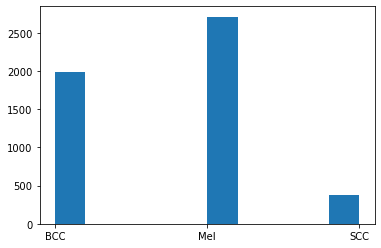

In [15]:
plt.hist(all_y)
plt.xticks([0,1,2], ['BCC', 'Mel', 'SCC'])
plt.show()